In [1]:
#import stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import holidays
sns.set_style('whitegrid')
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from bokeh.plotting import figure, show, output_file



/Users/anushag/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load data
countries_df = pd.read_csv('data/countries.csv')
session_df = pd.read_csv('data/sessions.csv')
test_df = pd.read_csv('data/test_users.csv')
train_df = pd.read_csv('data/train_users_2.csv')
age_gen_df = pd.read_csv('data/age_gender_bkts.csv')
session_df = session_df.rename(columns={'user_id':'id'})

In [3]:
train_len = train_df.shape[0]
test_len = test_df.shape[0]

In [4]:
#getinfo
train_df.info()
#test_df.info()
session_df.info()
#to be predicted is 'country destination'
country_percentage =  pd.DataFrame({'Percentage': train_df.groupby(('country_destination')).size() / len(train_df)*100})
country_percentage = country_percentage.reset_index()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB
<class 'pandas.core.frame.D

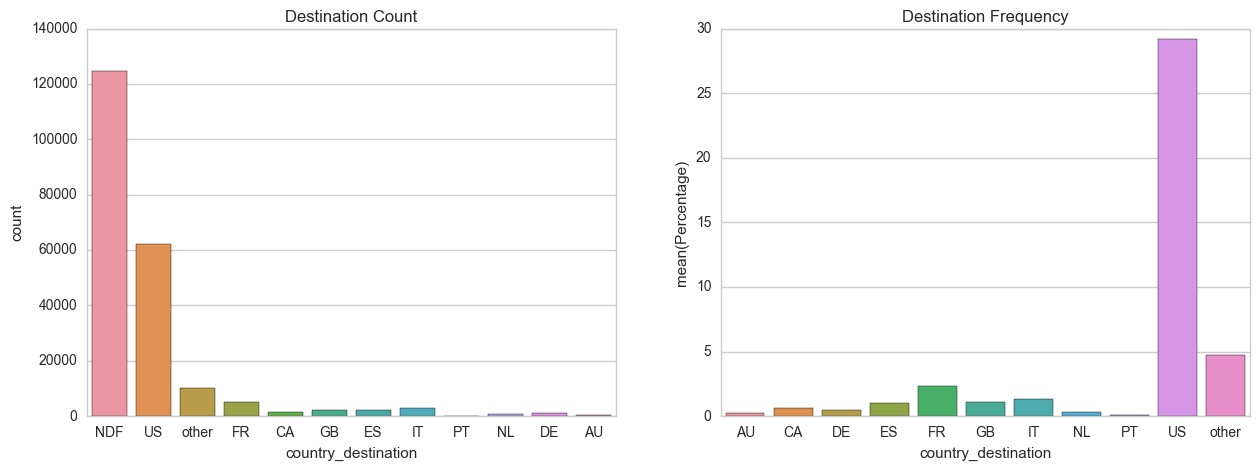

In [5]:
#total_count?
fig , (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x="country_destination",  data=train_df, ax=axis1);
axis1.set_title('Destination Count')
country_percentage = country_percentage[country_percentage['country_destination']!='NDF']
sns.barplot(x="country_destination", y='Percentage', data=country_percentage, ax=axis2)
axis2.set_title('Destination Frequency')

#sns.countplot(x="country_destination", hue='gender', data=data, ax=axis2);

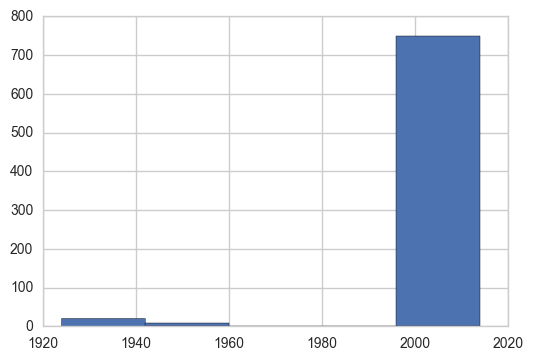

In [6]:
#cleaning up age values
train_df[train_df.age > 1000].age.hist(bins=5)
train_df['age'] = train_df['age'].apply(lambda x:  2015 - x if x> 1995 and x <1919 else x)
train_df['age'] = train_df['age'].apply(lambda x:  np.nan if x> 100 or x < 14 else x)

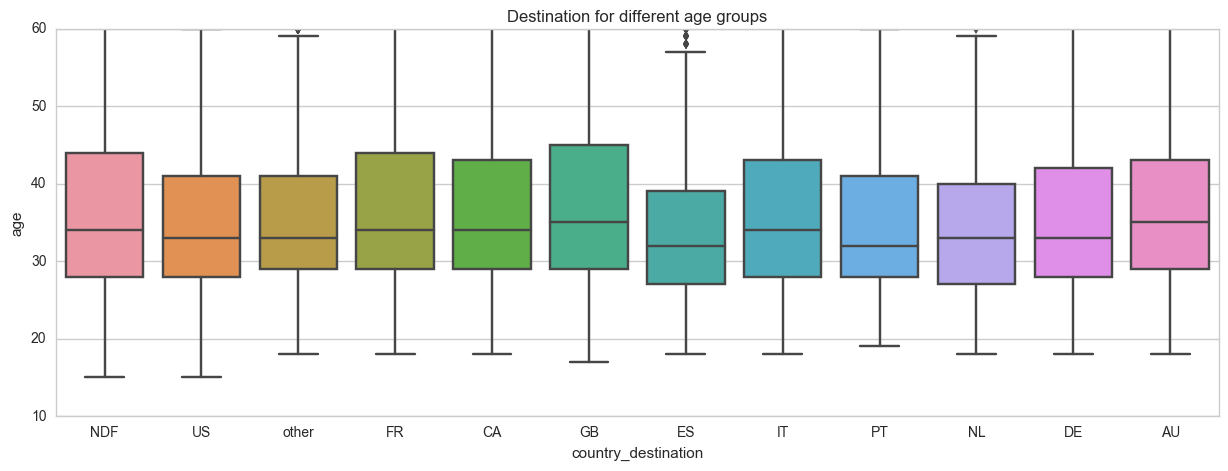

In [7]:
fig , (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(x='country_destination', y ='age', data=train_df, ax=axis1)
axis1.set_ylim([10,60])
axis1.set_title('Destination for different age groups')

Younger people travel to countries like Spain and Portugal and older to GB.

In [8]:
#merging session and train_df
#data = pd.merge(session_df,train_df, how='left', on='id')
data = train_df.merge(countries_df, how='left', on = 'country_destination')
data['booked'] = (data['country_destination'] != 'NDF').astype(int)
data.iloc[1234:1240]
train_df.iloc[1234:1240]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1234,3orxysy22l,2010-07-29,20100729231302,2010-08-05,-unknown-,36.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,Firefox,US
1235,o4l9hcz9x6,2010-07-29,20100729231511,2010-07-29,MALE,31.0,facebook,3,en,direct,direct,linked,Web,Mac Desktop,Chrome,US
1236,9beo2vk65h,2010-07-29,20100729235813,2010-07-30,MALE,34.0,basic,3,en,seo,google,untracked,Web,iPhone,-unknown-,US
1237,5e40r5naad,2010-07-30,20100730014043,NaN,MALE,37.0,facebook,2,en,direct,direct,untracked,Web,Mac Desktop,Safari,NDF
1238,sdoa75hc7f,2010-07-30,20100730035037,2010-08-03,-unknown-,58.0,basic,2,en,seo,google,linked,Web,Mac Desktop,Chrome,GB
1239,6vpmryt377,2010-07-30,20100730055204,2010-07-30,FEMALE,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,CA


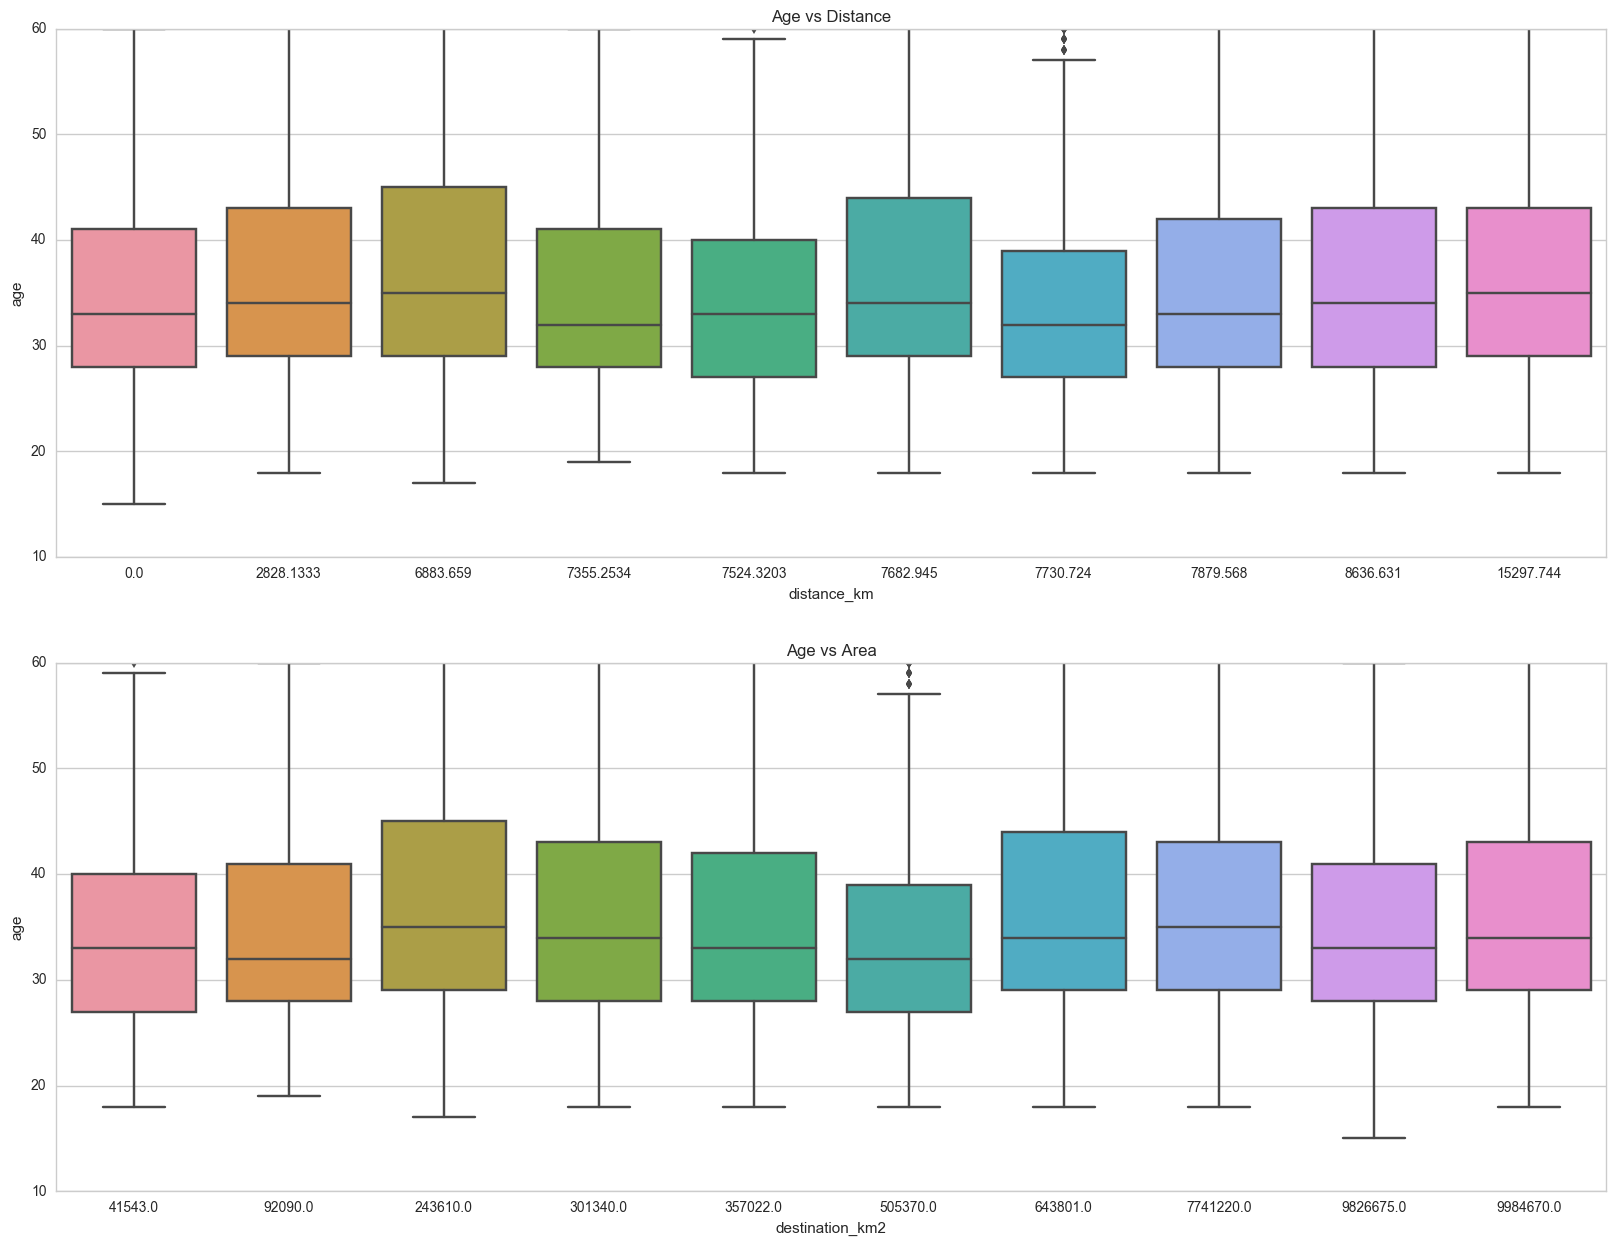

In [9]:
fig , (axis1,axis2) = plt.subplots(2,1,figsize=(20,15))
sns.boxplot(x='distance_km', y ='age',  data=data, ax=axis1)
sns.boxplot(x='destination_km2', y='age', data=data, ax=axis2)
axis1.set_ylim([10,60])
axis2.set_ylim([10,60])
axis1.set_title('Age vs Distance')
axis2.set_title('Age vs Area')

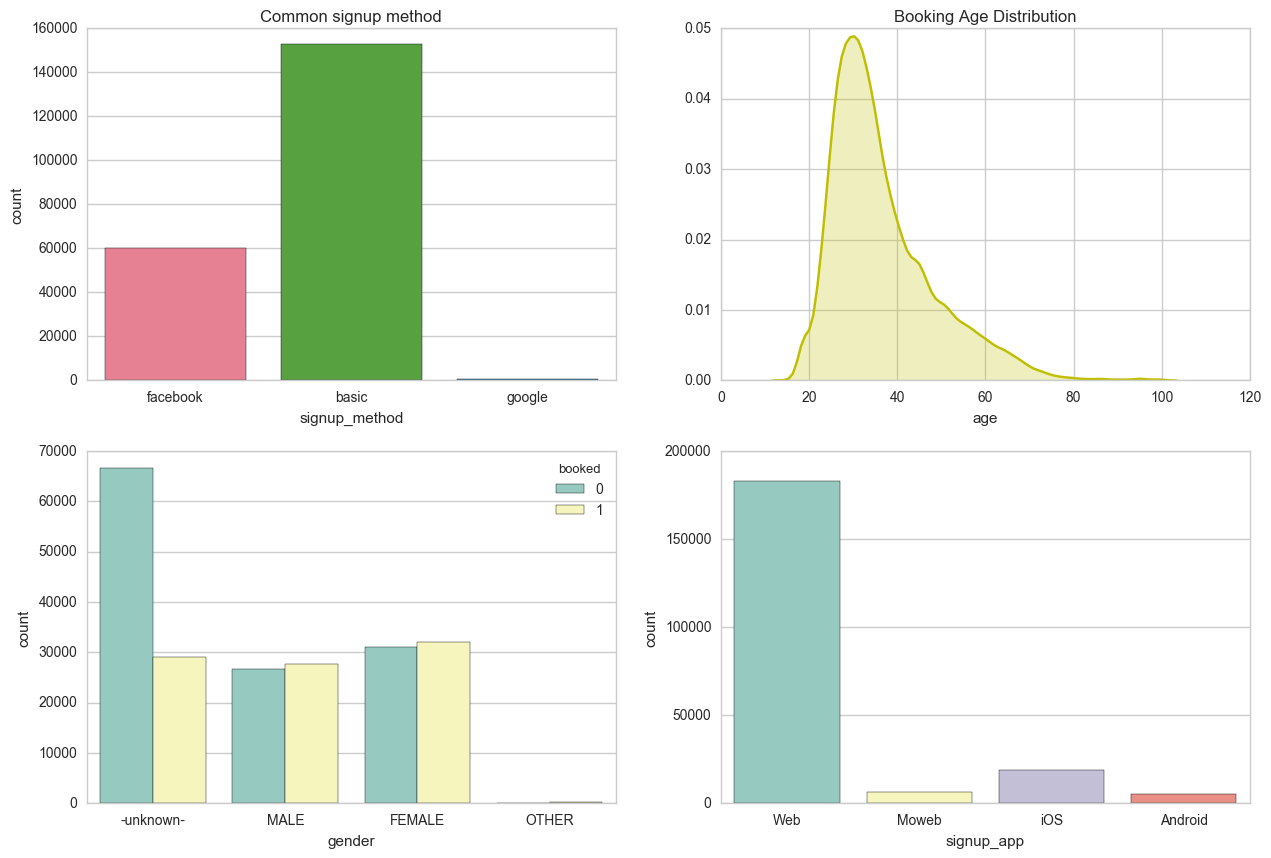

In [90]:
fig , ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

sns.countplot('signup_method', data=train_df, palette='husl', ax=ax1)
ax1.set_title('Common signup method')

sns.distplot(train_df.age.dropna(), hist=False, color="y", ax=ax2, kde_kws={"shade": True})
ax2.set_title('Booking Age Distribution')

#gender_data = train_df[train_df['gender'].apply(lambda x: x in ('MALE','FEMALE'))]
#sns.boxplot(x="country_destination", y="age", hue="gender", data=gender_data, palette="RdBu_r", ax=ax4)
#ax4.set_title('Gender Distribution')

sns.countplot(x='gender', hue ='booked', data=data, palette='Set3', ax=ax3)
#ax3.set_title('Booking Gender Distribution')

#sns.countplot('gender', data=train_df, ax=ax3, palette='Set3')

#data['date_first_booking'] = pd.to_datetime(data['date_first_booking'])
#data['booking_year'] = data['date_first_booking'].dt.year
#data['booking_year'].fillna(data['booking_year'].median(), inplace=True)
##sns.countplot(x='booking_year',  hue="booked", data=data, palette = 'Set2', ax=ax5)
#ax5.set_title('Booking year distribution')
#fig , ax6 = plt.subplots(1,1, figsize=(5,5))
sns.countplot(x='signup_app', data=data, palette='Set3', ax=ax4)
#ax4.set_title('Signup App distribution')

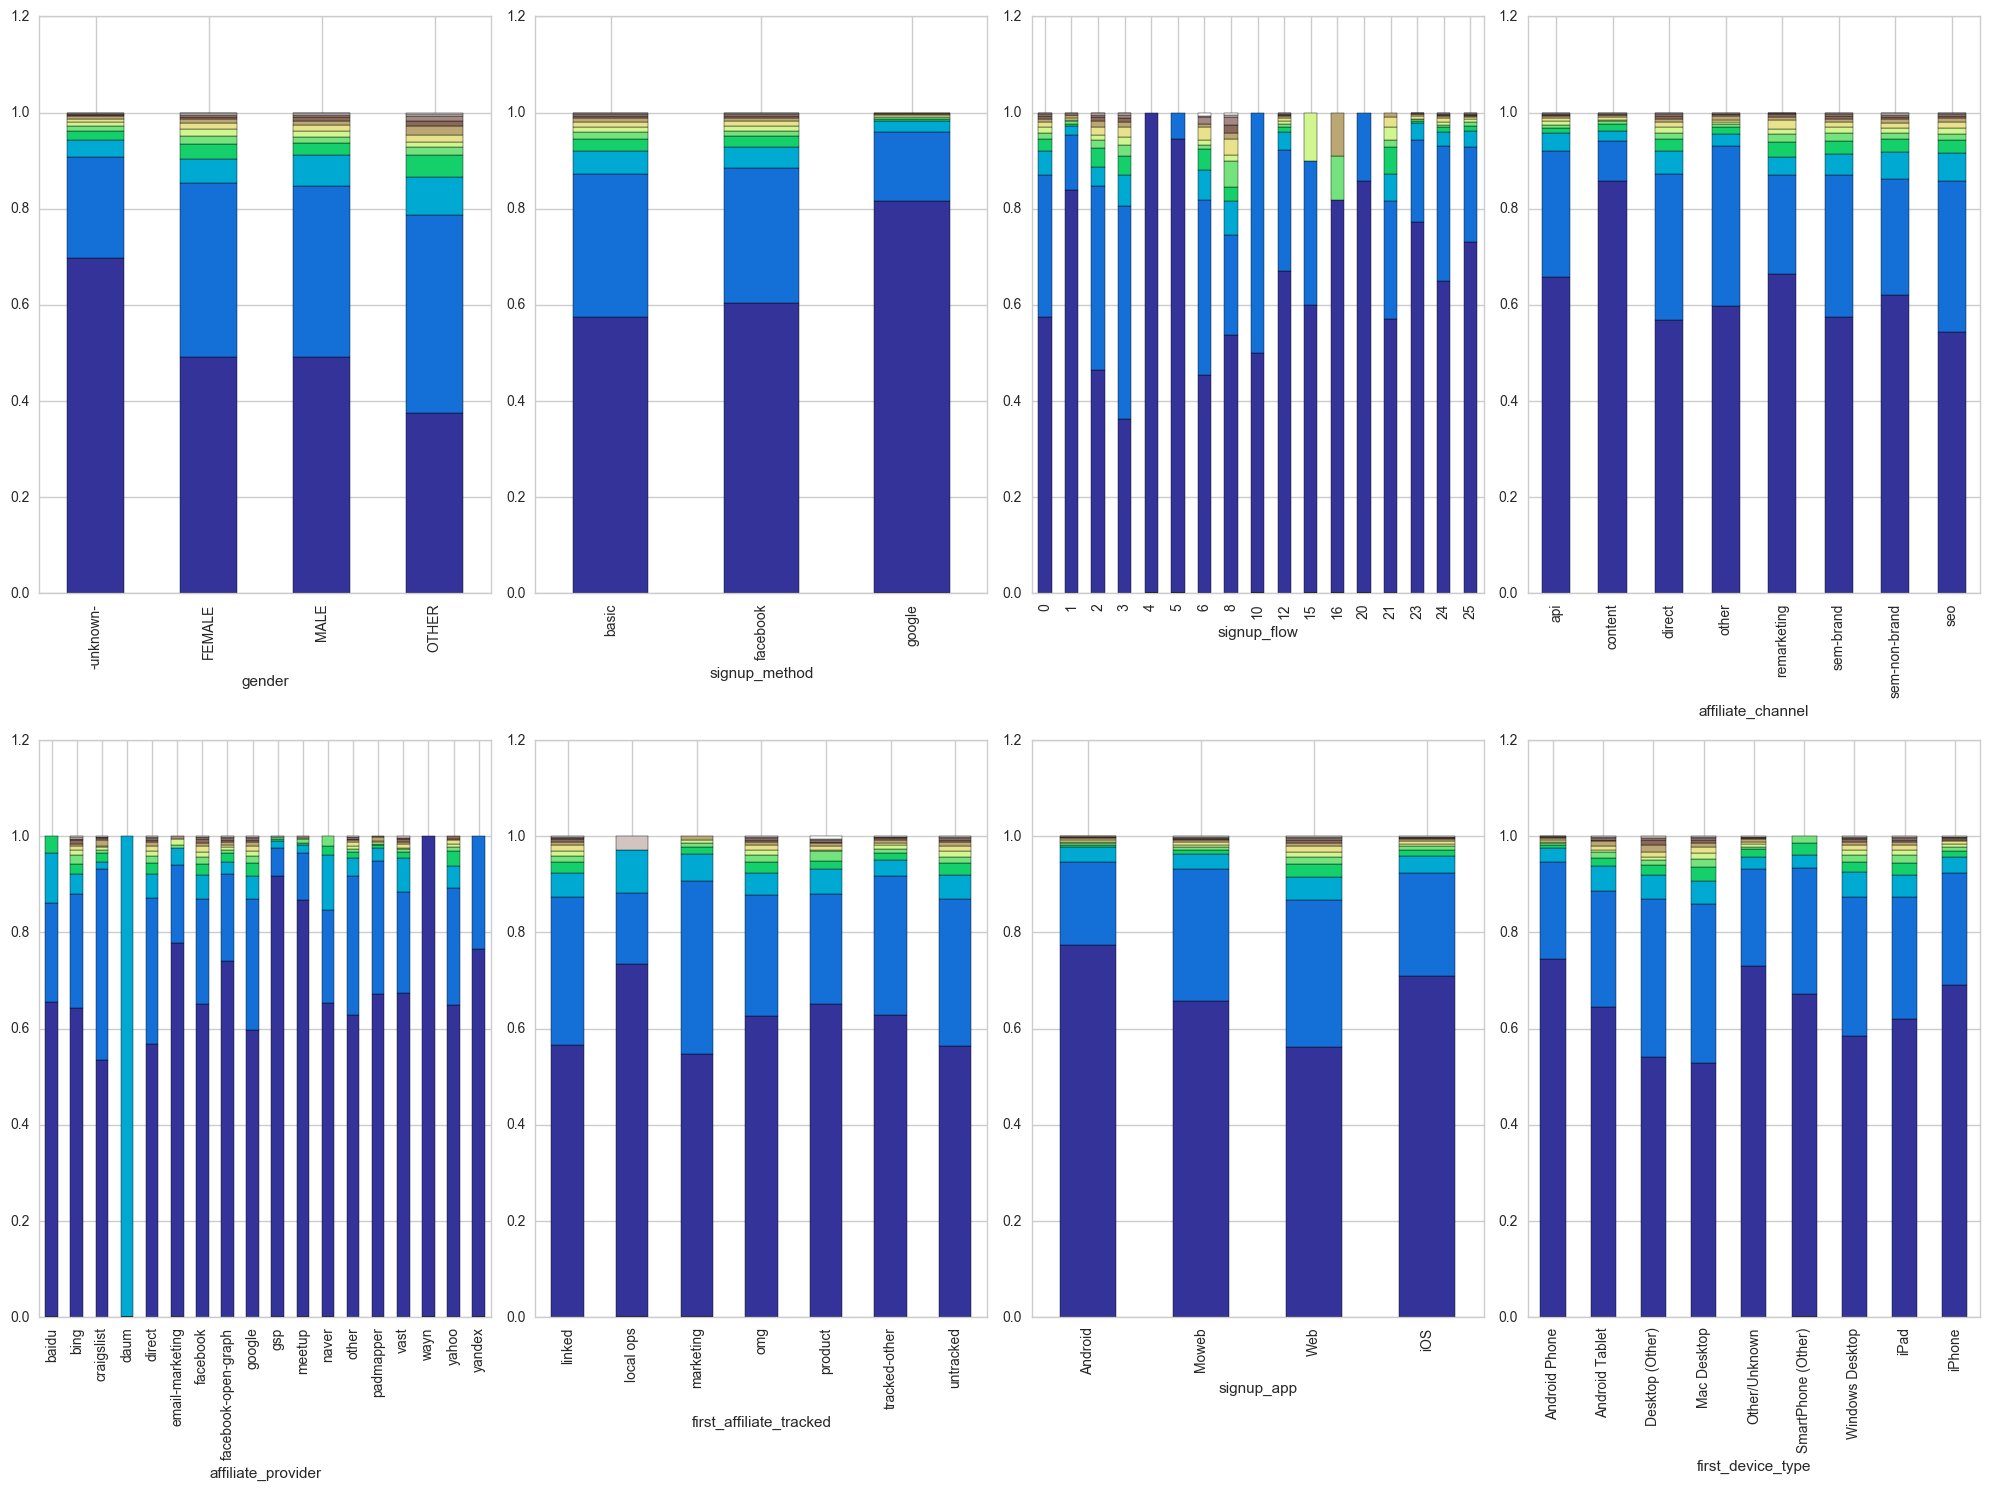

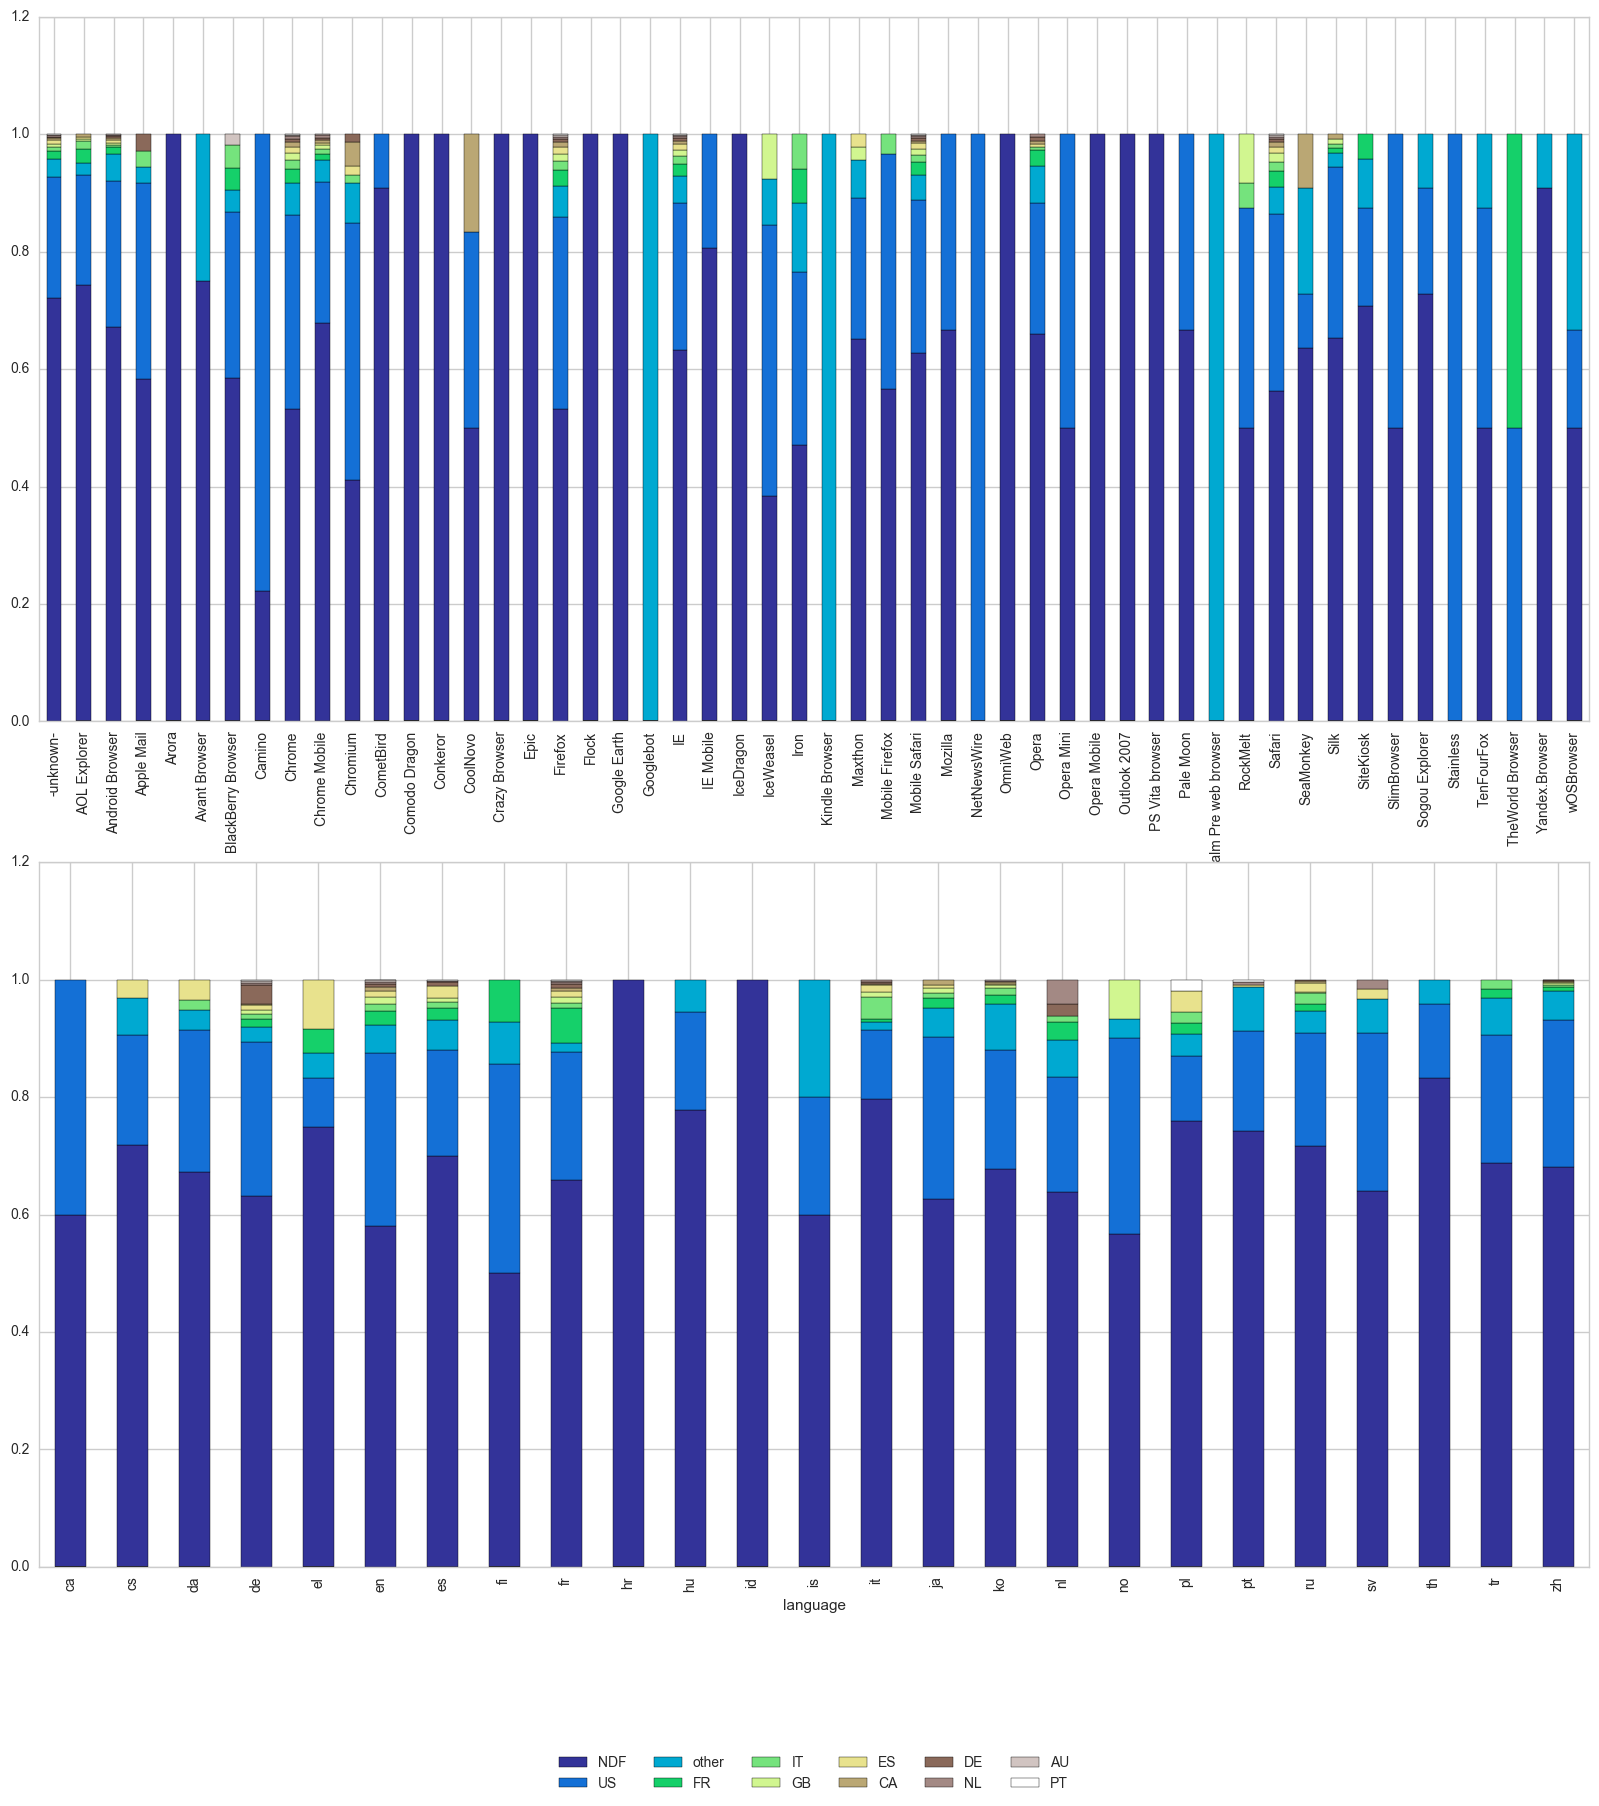

In [11]:
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['gender', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider', 
            'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'language']

fig, ax4 = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
def pltCatVar(var,axis,ax_num):
    ctab = pd.crosstab([train_df[var]], train_df.country_destination).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num],legend=False, 
                         colormap='terrain')
for i,var in enumerate(cat_vars[:8]):
    pltCatVar(var,ax4,i)
plt.tight_layout()
fig, ax5 = plt.subplots(nrows=2, ncols=1, figsize=(20, 20), sharey=True)
for i,var in enumerate(cat_vars[8:]):
    pltCatVar(var,ax5,i)
box = ax5[0].get_position()
#ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
ax5[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6)

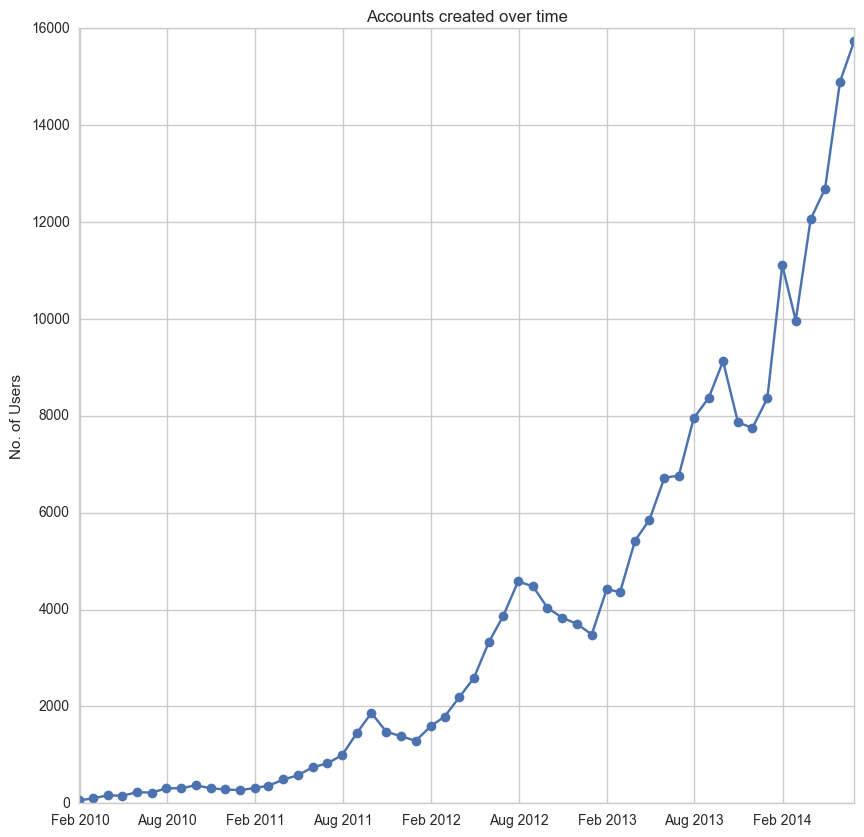

In [23]:
#accounts created over time
data['date_account_created'] = pd.to_datetime(data['date_account_created'])
time = data.groupby('date_account_created')['id'].count().reset_index()
data2 = time.set_index('date_account_created')
#data2.resample('A').sum()
data2 = data2.groupby([pd.TimeGrouper('M')]).sum()
plt.figure(figsize=(10,10))
plt.plot(data2, marker='o',)
plt.ylabel('No. of Users')
plt.title('Accounts created over time')

In [33]:
############### machine learning ############################
data_all = pd.concat((train_df, test_df),  axis=0, ignore_index=True)


In [34]:
#fixed time columns
data_all['date_account_created'] = pd.to_datetime(data_all['date_account_created'], format='%Y-%m-%d')
data_all['timestamp_first_active'] = pd.to_datetime(data_all['timestamp_first_active'], format='%Y%m%d%H%M%S')
data_all['date_account_created'].fillna(data_all.timestamp_first_active, inplace=True)

In [35]:
#drop date_first_booking since cannot be used for prediction
data_all.drop('date_first_booking' ,axis=1, inplace=True)

In [36]:
#fixing age values
data_all['age'] = train_df['age'].apply(lambda x:  np.nan if x> 90 or x <15 else x)
data_all['age'].fillna(-1, inplace=True)


In [37]:
#clean first_affiliate_tracked
data_all['first_affiliate_tracked'].fillna(-1,inplace=True)

In [29]:
#data_all['affiliate_channel'].replace('other', 'ch_other',inplace=True)
#data_all['affiliate_channel'].replace('direct', 'ch_direct',inplace=True)



In [38]:
def my_method(df, column_to_convert):
    r = pd.get_dummies(df[column_to_convert], prefix=column_to_convert)
    return r

# One Hot Encoding
print("One Hot Encoding categorical data...")
columns_to_convert = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

for column in columns_to_convert:
    g = my_method(df=data_all, column_to_convert=column)
    data_all = pd.concat((data_all,g), axis=1)
    data_all.drop(column, axis=1, inplace=True)


One Hot Encoding categorical data...


In [39]:
# Add new date related fields
print("Adding new fields...")
data_all['day_account_created'] = data_all['date_account_created'].dt.weekday
data_all['month_account_created'] = data_all['date_account_created'].dt.month
#data_all['quarter_account_created'] = data_all['date_account_created'].dt.quarter
data_all['year_account_created'] = data_all['date_account_created'].dt.year
data_all['hour_first_active'] = data_all['timestamp_first_active'].dt.hour
data_all['day_first_active'] = data_all['timestamp_first_active'].dt.weekday
data_all['month_first_active'] = data_all['timestamp_first_active'].dt.month
#data_all['quarter_first_active'] = data_all['timestamp_first_active'].dt.quarter
data_all['year_first_active'] = data_all['timestamp_first_active'].dt.year
#data_all['created_less_active'] = (data_all['date_account_created'] - data_all['timestamp_first_active']).dt.days

# Drop unnecessary columns
columns_to_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination']
for column in columns_to_drop:
    if column in data_all.columns:
        data_all.drop(column, axis=1, inplace=True)

Adding new fields...


In [40]:
data_all.drop('id', axis=1, inplace=True)

In [41]:
X_train = data_all[:train_len]
labels = train_df['country_destination']
le = LabelEncoder()
y_train = le.fit_transform(labels)
X_test = data_all[train_len:]

In [42]:
xgb = XGBClassifier( max_depth=6, learning_rate=0.3, n_estimators=25, objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)

In [44]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=25, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

In [45]:
y_pred = xgb.predict_proba(X_test)

In [46]:
cts = []
for i in range(len(X_test)):
    cts+= le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()


['NDF', 'US', 'other', 'IT', 'FR']

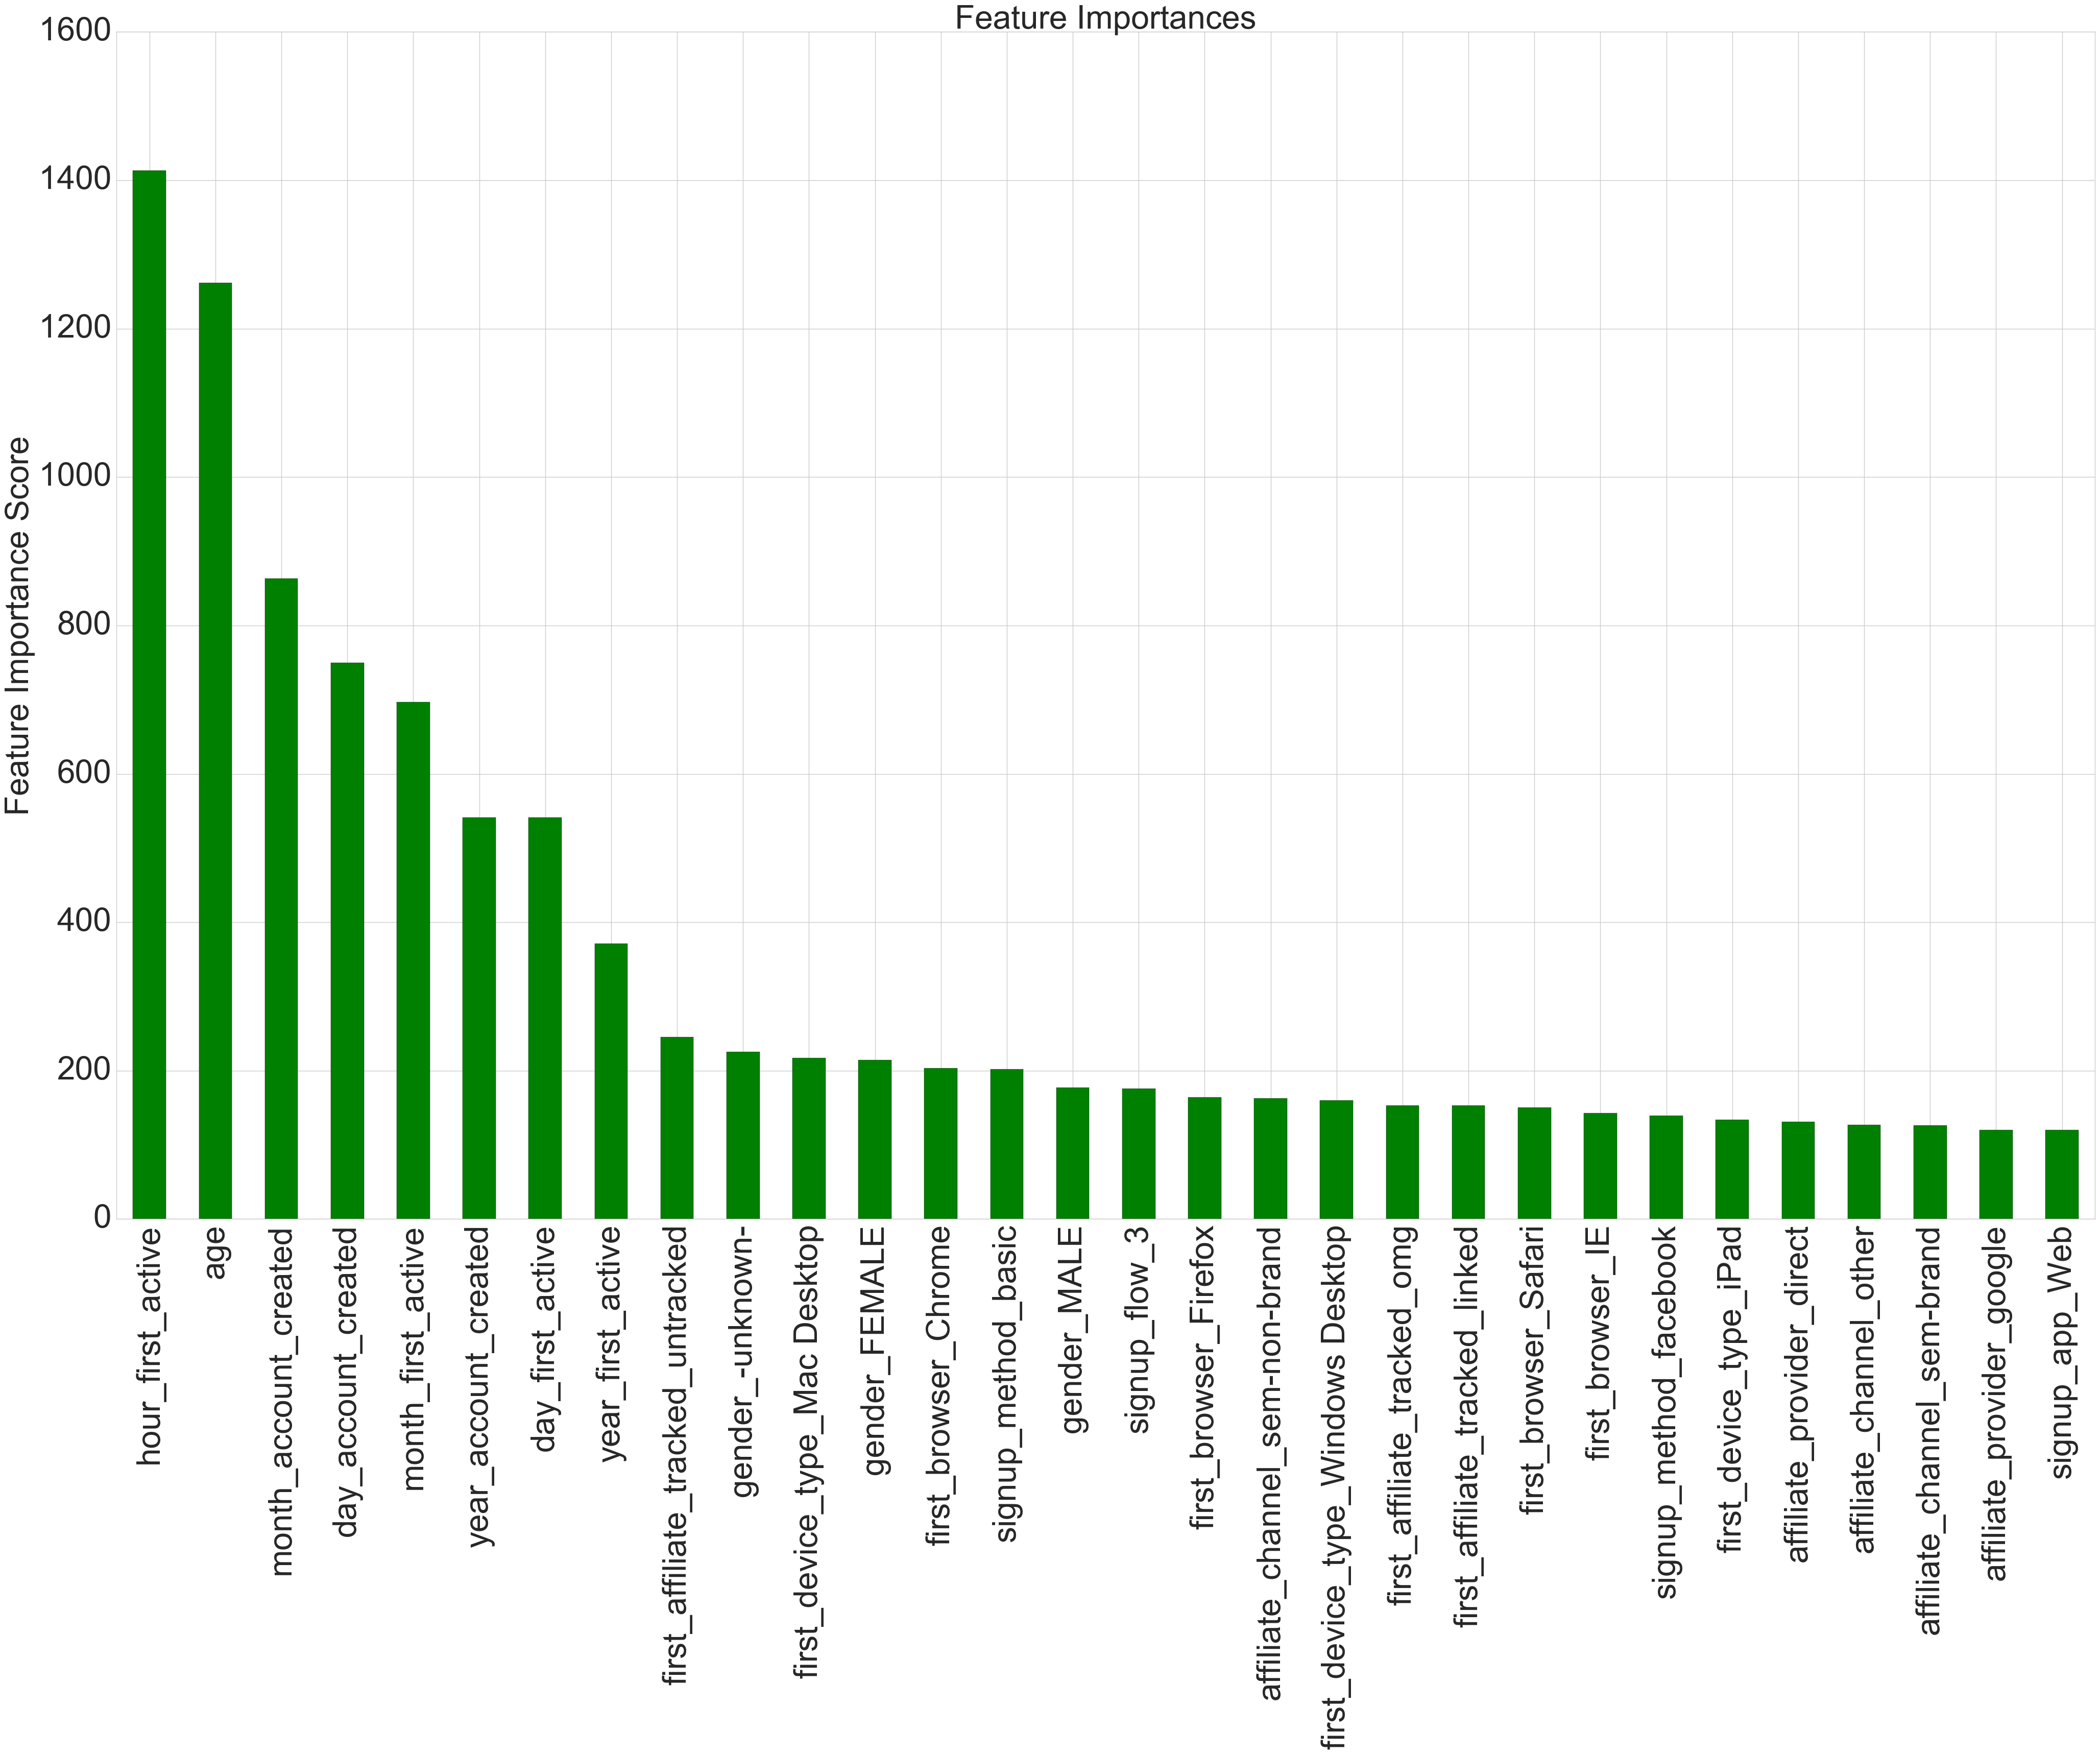

In [103]:
feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(50,30))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


feat_imp[0:30].plot( kind='bar', title='Feature Importances', colormap='ocean')

plt.ylabel('Feature Importance Score')


In [60]:
id_test = test_df['id']
ids = []
cts = []
for i in range(len(id_test)):
     idx = id_test[i]
     ids += [idx] * 5
     cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()
        

#

In [94]:
feat_imp[0:30]

hour_first_active                    1413
age                                  1262
month_account_created                 863
day_account_created                   750
month_first_active                    697
year_account_created                  541
day_first_active                      541
year_first_active                     371
first_affiliate_tracked_untracked     245
gender_-unknown-                      225
first_device_type_Mac Desktop         217
gender_FEMALE                         214
first_browser_Chrome                  203
signup_method_basic                   202
gender_MALE                           177
signup_flow_3                         176
first_browser_Firefox                 164
affiliate_channel_sem-non-brand       163
first_device_type_Windows Desktop     160
first_affiliate_tracked_omg           153
first_affiliate_tracked_linked        153
first_browser_Safari                  150
first_browser_IE                      143
signup_method_facebook            

In [62]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [80]:

pred_country_percentage =  pd.DataFrame({'Percentage': sub.groupby(('country')).size() / len(sub)*100})
pred_country_percentage = pred_country_percentage.reset_index()   

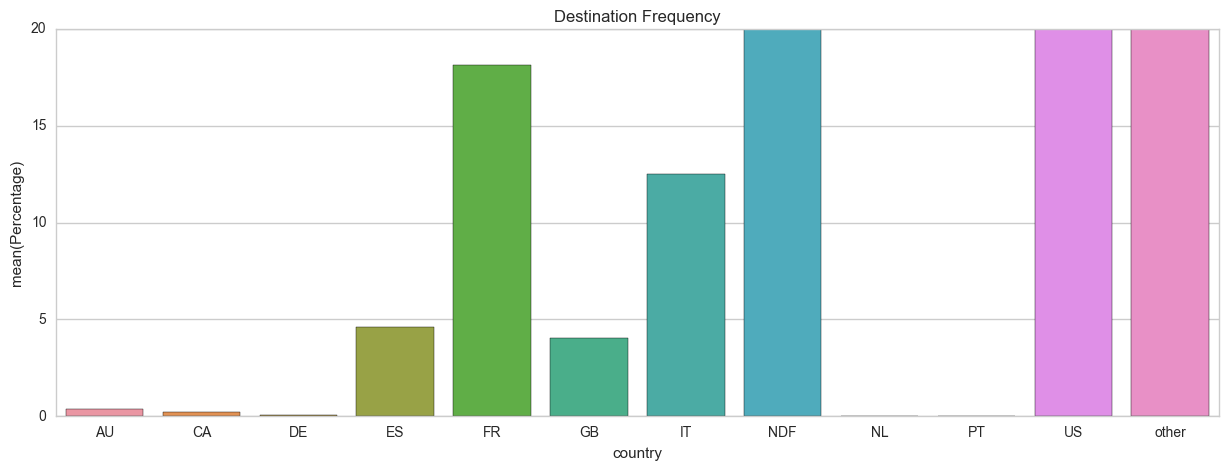

In [81]:
fig , (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x="country", y='Percentage', data=pred_country_percentage, ax=axis1)
axis1.set_title('Destination Frequency')

In [ ]:
feat_imp.to_csv('feature_imp.csv')

In [ ]:
data2.to_csv('user_info.csv')

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
X_tr, X_te, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=7)
xgb.fit(X_tr, y_tr)
# make predictions for test data
y_pred = xgb.predict(X_te)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.35%
